In [78]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN

In [79]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", DEVICE)

Using device: cuda


In [80]:
VIDEO_DIRS = ["./validation/1/", "./validation/0/"]
OUTPUT_DIRS = ["./output_val/1/", "./output_val/0/"]

In [81]:
VALIDATION_INPUT_DIRS = ["./validation/0/", "./validation/1/"]
VALIDATION_OUTPUT_DIRS = ["./output_val/0/", "./output_val/1/"]

In [82]:
def expand_bbox(x, y, w, h, fw, fh, frac):
    dw, dh = int(w * frac), int(h * frac)
    x0 = max(0, x - dw)
    y0 = max(0, y - dh)
    x1 = min(fw, x + w + dw)
    y1 = min(fh, y + h + dh)
    return (x0, y0, x1 - x0, y1 - y0)

def crop_and_resize(frame, bbox, out_size):
    x, y, w, h = bbox
    x2, y2 = x + w, y + h
    hF, wF = frame.shape[:2]

    x, y = max(0, x), max(0, y)
    x2, y2 = min(wF, x2), min(hF, y2)

    crop = frame[y:y2, x:x2]

    if crop.size == 0:
        # fallback: center square
        s = min(hF, wF)
        cx, cy = wF // 2, hF // 2
        crop = frame[cy-s//2:cy+s//2, cx-s//2:cx+s//2]

    return cv2.resize(crop, out_size)

In [83]:
# Initialize MTCNN
mtcnn = MTCNN(keep_all=True, device=str(DEVICE))

def extract_faces_from_frames(input_folder, output_folder, num_frames=30, out_size=OUT_SIZE, margin=0.35):
    """
    Extract faces from sequence of frames (JPG files)
    Input: folder dengan 01.jpg, 02.jpg, ..., 30.jpg
    Output: folder dengan cropped faces 01.jpg, 02.jpg, ..., 30.jpg
    """
    
    os.makedirs(output_folder, exist_ok=True)
    
    prev_bbox = None
    success_count = 0
    
    for idx in range(1, num_frames + 1):
        frame_name = f"{idx:02d}.jpg"
        frame_path = os.path.join(input_folder, frame_name)
        
        if not os.path.exists(frame_path):
            print(f"  ⚠️ Missing: {frame_name}")
            # Create blank image if missing
            blank = np.zeros((out_size[1], out_size[0], 3), np.uint8)
            cv2.imwrite(os.path.join(output_folder, frame_name), blank)
            continue
        
        # Read frame
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"  ⚠️ Cannot read: {frame_name}")
            blank = np.zeros((out_size[1], out_size[0], 3), np.uint8)
            cv2.imwrite(os.path.join(output_folder, frame_name), blank)
            continue
        
        # Detect face
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = mtcnn.detect(rgb)
        
        if boxes is None or len(boxes) == 0:
            # No face detected, use previous bbox or center square
            if prev_bbox is None:
                hF, wF = frame.shape[:2]
                s = min(hF, wF)
                cx, cy = wF // 2, hF // 2
                bbox = (cx - s//2, cy - s//2, s, s)
            else:
                bbox = prev_bbox
        else:
            # Pick largest box
            areas = [(b[2]-b[0])*(b[3]-b[1]) for b in boxes]
            i = int(np.argmax(areas))
            x1, y1, x2, y2 = boxes[i]
            bbox = (int(x1), int(y1), int(x2 - x1), int(y2 - y1))
        
        # Expand bbox and crop
        bbox_exp = expand_bbox(*bbox, frame.shape[1], frame.shape[0], margin)
        face = crop_and_resize(frame, bbox_exp, out_size)
        prev_bbox = bbox_exp
        
        # Save cropped face
        out_path = os.path.join(output_folder, frame_name)
        cv2.imwrite(out_path, face)
        success_count += 1
    
    return success_count == num_frames

In [84]:
def batch_process_validation(input_base_dir, output_base_dir, num_frames=30):
    """
    Process all sequence folders in validation set
    Input: validation/0/test_seq_xxxxx/*.jpg
    Output: output_val/0/test_seq_xxxxx/*.jpg (cropped faces)
    """
    
    os.makedirs(output_base_dir, exist_ok=True)
    
    # Get all sequence folders
    sequence_folders = sorted([f for f in os.listdir(input_base_dir) 
                              if os.path.isdir(os.path.join(input_base_dir, f))])
    
    if len(sequence_folders) == 0:
        print(f"⚠️ No sequence folders found in: {input_base_dir}")
        return pd.DataFrame()
    
    results = []
    
    print(f"\nProcessing {len(sequence_folders)} sequences from: {input_base_dir}")
    
    for seq_name in tqdm(sequence_folders, desc="Extracting faces"):
        input_folder = os.path.join(input_base_dir, seq_name)
        output_folder = os.path.join(output_base_dir, seq_name)
        
        # Extract faces from frames
        success = extract_faces_from_frames(input_folder, output_folder, num_frames)
        
        results.append({
            "sequence_name": seq_name,
            "input_folder": input_folder,
            "output_folder": output_folder,
            "success": success
        })
    
    df = pd.DataFrame(results)
    
    # Save manifest
    manifest_path = os.path.join(output_base_dir, "manifest.csv")
    df.to_csv(manifest_path, index=False)
    
    print(f"\n✅ Processed {len(df)} sequences")
    print(f"   Success: {df['success'].sum()}/{len(df)}")
    print(f"   Manifest saved to: {manifest_path}")
    
    return df

In [85]:
def show_frames(folder, cols=6, figsize=(12,8)):
    """Display frames from a folder"""
    files = sorted([f for f in os.listdir(folder) if f.endswith(".jpg")])
    
    if len(files) == 0:
        print(f"No JPG files found in: {folder}")
        return
    
    rows = int(np.ceil(len(files)/cols))
    plt.figure(figsize=figsize)

    for i, fn in enumerate(files):
        img = cv2.imread(os.path.join(folder, fn))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.title(fn, fontsize=8)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

FACE EXTRACTION FOR VALIDATION SET

Processing Label: 0 (Non-Drowsy)
  Input:  ./validation/0/
  Output: ./output_val/0/

Processing 105 sequences from: ./validation/0/


Extracting faces:   0%|          | 0/105 [00:00<?, ?it/s]


✅ Processed 105 sequences
   Success: 105/105
   Manifest saved to: ./output_val/0/manifest.csv

📸 Sample output from: test_seq_00002


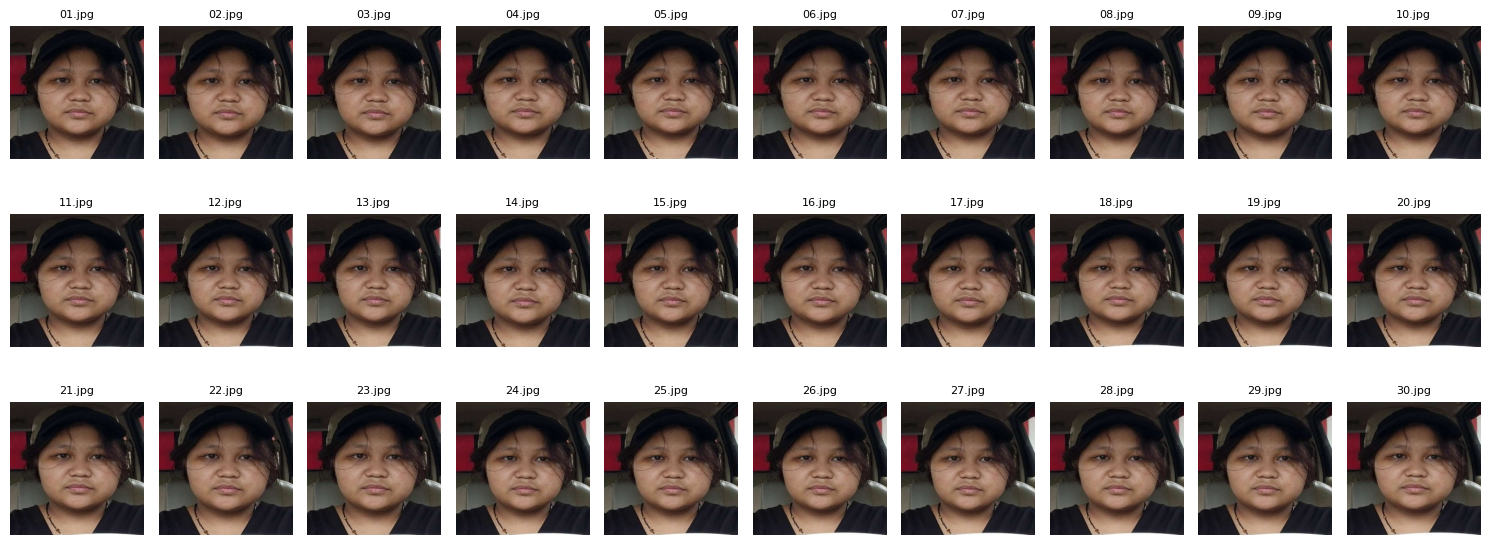


Processing Label: 1 (Drowsy)
  Input:  ./validation/1/
  Output: ./output_val/1/

Processing 45 sequences from: ./validation/1/


Extracting faces:   0%|          | 0/45 [00:00<?, ?it/s]


✅ Processed 45 sequences
   Success: 45/45
   Manifest saved to: ./output_val/1/manifest.csv

📸 Sample output from: test_seq_00001


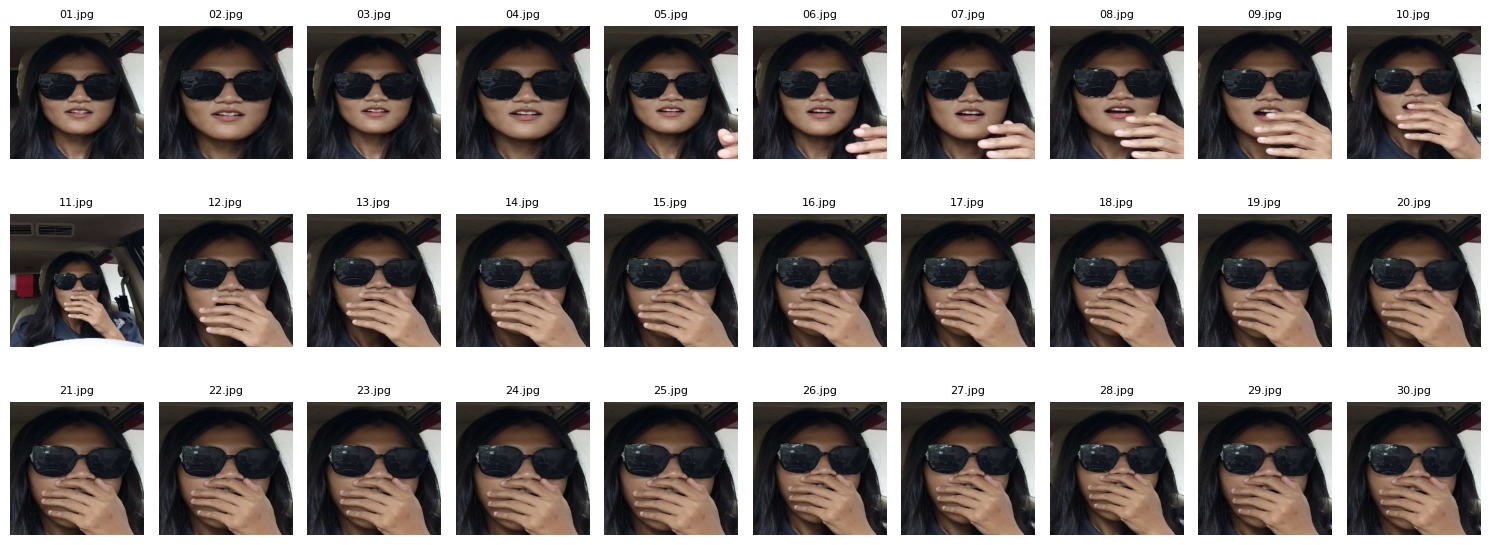


FACE EXTRACTION COMPLETE!

Summary:
  Total sequences processed: 150
  Successful: 150
  Failed: 0

Output folders:
  ✅ ./output_val/0/
  ✅ ./output_val/1/


In [86]:
# Process validation data
print("=" * 80)
print("FACE EXTRACTION FOR VALIDATION SET")
print("=" * 80)

all_manifests = []

for input_dir, output_dir in zip(VALIDATION_INPUT_DIRS, VALIDATION_OUTPUT_DIRS):
    label = "1 (Drowsy)" if "1" in input_dir else "0 (Non-Drowsy)"
    
    print(f"\n{'='*80}")
    print(f"Processing Label: {label}")
    print(f"  Input:  {input_dir}")
    print(f"  Output: {output_dir}")
    print(f"{'='*80}")
    
    manifest = batch_process_validation(input_dir, output_dir, NUM_FRAMES)
    all_manifests.append(manifest)
    
    # Show sample
    if len(manifest) > 0:
        sample_folder = manifest.iloc[0]['output_folder']
        print(f"\n📸 Sample output from: {manifest.iloc[0]['sequence_name']}")
        show_frames(sample_folder, cols=10, figsize=(15, 6))

print("\n" + "=" * 80)
print("FACE EXTRACTION COMPLETE!")
print("=" * 80)

# Summary
total_sequences = sum(len(m) for m in all_manifests)
total_success = sum(m['success'].sum() for m in all_manifests)

print(f"\nSummary:")
print(f"  Total sequences processed: {total_sequences}")
print(f"  Successful: {total_success}")
print(f"  Failed: {total_sequences - total_success}")

print(f"\nOutput folders:")
for output_dir in VALIDATION_OUTPUT_DIRS:
    print(f"  ✅ {output_dir}")


VISUAL COMPARISON: Before vs After Face Extraction


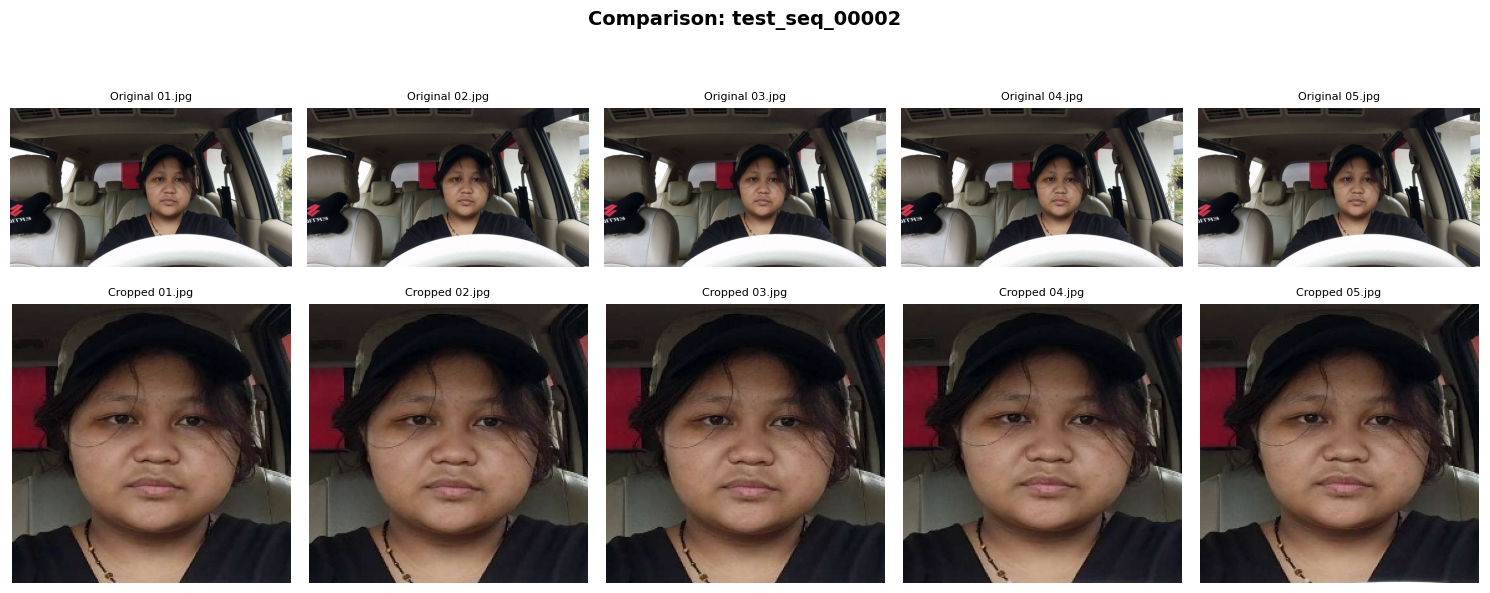

✅ Visual comparison shown above


In [87]:
# Compare before and after (Optional - untuk validasi visual)
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Before vs After Face Extraction")
print("=" * 80)

if len(all_manifests[0]) > 0:
    sample = all_manifests[0].iloc[0]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Comparison: {sample['sequence_name']}", fontsize=14, fontweight='bold')
    
    # Show first 5 frames
    for i in range(5):
        frame_name = f"{i+1:02d}.jpg"
        
        # Original
        original_path = os.path.join(sample['input_folder'], frame_name)
        if os.path.exists(original_path):
            img = cv2.imread(original_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img)
            axes[0, i].set_title(f"Original {frame_name}", fontsize=8)
            axes[0, i].axis('off')
        
        # Cropped face
        cropped_path = os.path.join(sample['output_folder'], frame_name)
        if os.path.exists(cropped_path):
            img = cv2.imread(cropped_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img)
            axes[1, i].set_title(f"Cropped {frame_name}", fontsize=8)
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visual comparison shown above")